# Crystal Size Distribution for a cooling liquid

This notebook is a first attempt to model the evolution of the crystal size
distribution (CSD) as a function of time as a packet of liquid cools through
its melting temperature. The general idea is based on Spillar and Dolejs (2013;
Journal of Petrology 54:913-931) but instead of attempting to invert a measured
CSD to find cooling history we will impose a cooling history and calculate the
resulting CSD. Another paper worth reading is Marsh (1998; Journal of Petrology 
39:553-599), which sets up much of the background.

The CSD, $n(L, t)$ describes the number density of crystals of radius $L$ in a
volume of liquid at time $t$. Its evolution with time depends on a balance of 
the nucleation rate, $I$, and the crystal growth rate, $G$. Both of these are 
functions that are equal to zero at the melting temperature, $T_m$, and which
increase with undercolling. For almost all igneous rocks all the melt has
crystalised and this imposes geometic  constraints that modifies the
behaviour of $I$ and $G$. But we are interested in low crystallinity, so
we will assume that $I$ and $G$ are only controlled by the thermodynamic 
and kintetic effects.

I will use some data for Cu, because this seems to be hanging around, assume
growth rate is linear, and take a simple form for G (really we should use
equation 5 from Davies et al. 2019; EPSL 507:1-9, but that has too many terms for
me today).


In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Data for Cu (because I have a EAM set up in LAMMPS for Cu in case we want to take it further)

kB = 1.380649e-23 # J/K
cu_k0 = 212 * 1E-4 # [K^-1]? Table 2 # and made 1000 times smaller
cu_tm = 1275 # [K] Table 1
cu_dhm = 1.21 * kB * cu_tm # [J] SI table S1, heat of fusion at melting point
g_factor = 2E6 # A constant for the nucleation rate.

In [3]:
def growth_rate(t, tm, dhm, k0):
    """
    Linear growth rate - see Sun et al. Nat Materials paper
    t is the temperature
    Tm is the melting temperature
    dmu is the difference in chekical potentials
    k0 is a rate constant
    r is the particle radius
    """
    d_mu = (tm - t) * (dhm / tm) # K13 / first para of Sun SI
    kB = 1.380649e-23 #J/K
    v = k0 * (1.0 - np.exp(-d_mu/(kB * t)))
    return v


In [4]:
def nucleation_rate(t, tm, dhm, surf_e):
    """
    Simple nucleation rate. Just say it goes with the square of the undercooling...
    ... need to do better
    t is the temperature
    Tm is the melting temperature
    dmu is the difference in chekical potentials
    k0 is a rate constant
    r is the particle radius
    """
    d_mu = (tm - t)**2 * (dhm / tm) # K13 / first para of Sun SI
    kB = 1.380649e-23 #J/K
    g = surf_e * (1.0 - np.exp(-d_mu/(kB * t)))
    return g

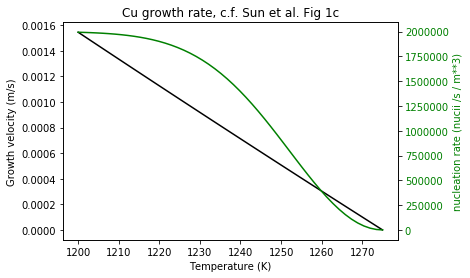

In [34]:
fig, ax = plt.subplots()
ts = np.linspace(1200, cu_tm)
vs = growth_rate(ts, cu_tm, cu_dhm, cu_k0)
gs = nucleation_rate(ts, cu_tm, cu_dhm, g_factor)
ax.plot(ts, vs, 'k')
ax2 = ax.twinx()
ax2.plot(ts, gs, 'g')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Growth velocity (m/s)')
ax2.tick_params(axis='y', labelcolor='g')
ax2.set_ylabel('nucleation rate (nucii /s / m**3)', color='g')
ax.set_title('Cu growth rate, c.f. Sun et al. Fig 1c')
plt.show()

We need some temperature history for our melt packet. Linear cooling for now.
We will run to 1200 K. So set up some empty arrays.

In [6]:
total_volume = 1.0 # m^3
initial_temperature = 1275.0 #  below tm!
cooling_rate = 0.1 # K/s
end_temperature = 1265 # K
# Volume is 1 m**3
max_time = (initial_temperature - end_temperature) / cooling_rate
print("Run time will be", max_time, "seconds")
time_step = 0.005 # s
n_steps = int(max_time / time_step)
print("Will run for", n_steps, "steps")
times = np.arange(0, max_time, time_step)

Run time will be 100.0 seconds
Will run for 20000 steps


In [7]:
# Set up discritisation for the CSD
# This is a log of the particle size
min_r = 0.000001
# We could integrate G to get Lmax (see S&D18) but let's just set up a fixed value
max_r = 0.1
num_r = 1000
sizes = np.geomspace(min_r, max_r, num=num_r, endpoint=True)
sizes_lower = np.zeros_like(sizes)
for i in range(1, num_r):
    sizes_lower[i] = sizes[i-1] + (sizes[i] - sizes[i-1])/2.0
    
print("Will have", num_r, "size bins in the csd with log distribution")
print("First bin runs from r = ", sizes_lower[0], "to r = ", sizes_lower[1], 
      "with r = ", sizes[0], "assumed")
print("Second bin runs from r = ", sizes_lower[1], "to r = ", sizes_lower[2], 
      "with r = ", sizes[1], "assumed")
print("Minimum dr to grow:", sizes_lower[1] - sizes[0])
print("Last bin runs from r = ", sizes_lower[-1], "upwards", 
      "with r = ", sizes[-1], "assumed")

Will have 1000 size bins in the csd with log distribution
First bin runs from r =  0.0 to r =  1.0057955561119148e-06 with r =  1e-06 assumed
Second bin runs from r =  1.0057955561119148e-06 to r =  1.0174538452770371e-06 with r =  1.0115911122238297e-06 assumed
Minimum dr to grow: 5.795556111914849e-09
Last bin runs from r =  0.09942708510959787 upwards with r =  0.1 assumed


In [8]:
# Build the CSD array
csd = np.zeros((n_steps, num_r), dtype='int')
print("csd array shape and size:", csd.shape, csd.size)

csd array shape and size: (20000, 1000) 20000000


In [9]:
start_time = time.time()
temperature_log = np.zeros_like(times)
crystalinity_log = np.zeros_like(times)

# Initial condition
temperature = initial_temperature
csd[0, :] = 0 
temperature_log[0] = temperature
crystalinity_log[0] = np.sum(csd[0,:] * (4/3) * np.pi * sizes**3) / total_volume

for ii, t in enumerate(times[1:]):
    i = ii + 1 # To deal with enumerate starting from 0.
    
    # Grow the CSD
    v = growth_rate(temperature, cu_tm, cu_dhm, cu_k0)
    assert v >= 0.0, "Not set up for dissolution"
    dr = v * time_step # How far does a surface grow?
    # Assume v is positive (growth)
    # and move from large to small growing crystals.
    # Move CSD from cell j in time t-1 to j+delta_j at time t
    csd[i, :] = 0 # start counting from zero for this timestep
    for j in range(num_r-1):
        if csd[i-1, j] == 0:
            # No particles to grow, skip!
            pass
        elif sizes[j] + dr < sizes_lower[j + 1]:
            # Particles not grown enough to get into next bin
            csd[i, j] = csd[i, j] + csd[i-1, j]
        else:
            for jj in range(num_r-1, j-1, -1):
                # Particles grown, add them to the correct bin
                if sizes[j] + dr > sizes_lower[jj]:
                    csd[i, jj] = csd[i, jj] + csd[i-1, j]
                    break
                assert "Error! Should never get here"
    # Particles in the biggest bin do not grow
    csd[i, num_r-1] = csd[i, num_r-1] + csd[i-1, num_r-1]
        
    # Nucleation (always at L=0, i.e assume nuclii are small)
    g = nucleation_rate(temperature, cu_tm, cu_dhm, g_factor) 
    csd[i,0] = csd[i,0] + int(g * time_step) # Assume 1 m**3 box
    
    temperature_log[i] = temperature
    crystalinity_log[i] = np.sum(csd[i,:] * (4/3) * np.pi * sizes**3) / total_volume
    
    
    if i%2500 == 0:
        print("\nStep:", i, "time:", t)
        print("temperature:", temperature, "g:", g, "v", v)
        print("dr", dr)
        print("New partcles this step", int(g * time_step))
        print("Max size particles this step", csd[i,-1])
        print("Total particles:", np.sum(csd[i,:]))
        print("Instant CSD sample (every 50th bin):", csd[i,::50])
        print("Instant crystalinity:", crystalinity_log[i])
        print("Wall time per timestep:", (time.time() - start_time) / i)
    if crystalinity_log[i] >= 1.0:
        print("\nFrozen!")
        print("\nStep:", i, "time:", t)
        print("temperature:", temperature, "g:", g, "v", v)
        print("dr", dr)
        print("New partcles this step", int(g * time_step))
        print("Max size particles this step", csd[i,-1])
        print("Total particles:", np.sum(csd[i,:]))
        print("Instant CSD sample (every 50th bin):", csd[i,::50])
        print("Instant crystalinity:", crystalinity_log[i])
        print("Wall time per timestep:", (time.time() - start_time) / i)
        break
    temperature = temperature - (cooling_rate*time_step)

print("Done")


Step: 2500 time: 12.5
temperature: 1273.7504999997454 g: 2964.022568005431 v 2.5148692114107796e-05
dr 1.25743460570539e-07
New partcles this step 14
Max size particles this step 0
Total particles: 11237
Instant CSD sample (every 50th bin): [14  0  0  0 13 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Instant crystalinity: 4.2570207434232103e-10
Wall time per timestep: 0.030381018829345702

Step: 5000 time: 25.0
temperature: 1272.5004999994908 g: 11846.070974886436 v 5.032692687623843e-05
dr 2.5163463438119216e-07
New partcles this step 59
Max size particles this step 0
Total particles: 96431
Instant CSD sample (every 50th bin): [59  0  0  0  0 57 56  0  0  0  0  0  0  0  0  0  0  0  0  0]
Instant crystalinity: 3.152779228294782e-08
Wall time per timestep: 0.0357052252292633

Step: 7500 time: 37.5
temperature: 1271.2504999992361 g: 26584.497484935855 v 7.552464947918516e-05
dr 3.776232473959258e-07
New partcles this step 132
Max size particles this step 0
Total particles: 329354
Insta

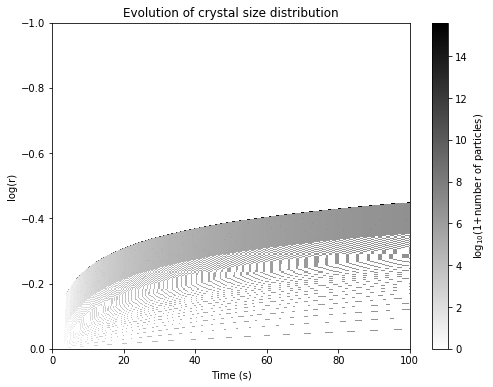

In [25]:
fig, ax = plt.subplots(figsize=(8,6))

extent = (0, max_time, 0, np.log10(max_r),)
cols = ax.imshow(np.log(csd[0::20,:]+1).T, aspect='auto', interpolation='none', origin='lower', 
                 cmap='gray_r', extent=extent)
ax.set_title('Evolution of crystal size distribution')
ax.set_xlabel('Time (s)')
ax.set_ylabel('log(r)')
cbar = fig.colorbar(cols, ax=ax)
cbar.ax.set_ylabel('log$_{10}$(1+number of particles)')

plt.show()

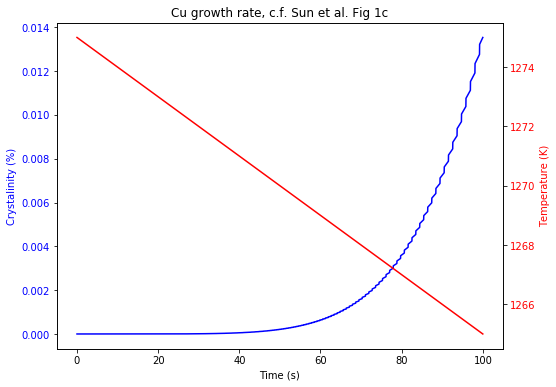

In [33]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(times, crystalinity_log*100, 'b')
ax2 = ax.twinx()
ax2.plot(times, temperature_log, 'r')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Crystalinity (%)', color='b' )
ax.tick_params(axis='y', labelcolor='b' )
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel('Temperature (K)', color='r')
ax.set_title('System evolution')

plt.show()